# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


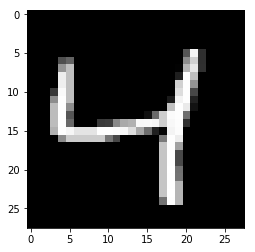

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [4]:
learning_rate = 0.001

# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1))
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1))

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, (3,3), strides=(1,1), padding='same', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 8, (3,3), strides=(1,1), padding='same', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, 8, (3,3), strides=(1,1), padding='same', activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, (3,3), strides=(1,1), padding='same', activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(encoded, (14,14))
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, (3,3), strides=(1,1), padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(encoded, (28,28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, (3,3), strides=(1,1), padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6, 1, (3,3), strides=(1,1), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [ ]:
sess = tf.Session()

In [ ]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6934
Epoch: 1/20... Training loss: 0.6834
Epoch: 1/20... Training loss: 0.6741
Epoch: 1/20... Training loss: 0.6640
Epoch: 1/20... Training loss: 0.6551
Epoch: 1/20... Training loss: 0.6459
Epoch: 1/20... Training loss: 0.6373
Epoch: 1/20... Training loss: 0.6256
Epoch: 1/20... Training loss: 0.6170
Epoch: 1/20... Training loss: 0.6047
Epoch: 1/20... Training loss: 0.5939
Epoch: 1/20... Training loss: 0.5868
Epoch: 1/20... Training loss: 0.5753
Epoch: 1/20... Training loss: 0.5730
Epoch: 1/20... Training loss: 0.5631
Epoch: 1/20... Training loss: 0.5651
Epoch: 1/20... Training loss: 0.5638
Epoch: 1/20... Training loss: 0.5733
Epoch: 1/20... Training loss: 0.5655
Epoch: 1/20... Training loss: 0.5530
Epoch: 1/20... Training loss: 0.5553
Epoch: 1/20... Training loss: 0.5607
Epoch: 1/20... Training loss: 0.5467
Epoch: 1/20... Training loss: 0.5435
Epoch: 1/20... Training loss: 0.5389
Epoch: 1/20... Training loss: 0.5383
Epoch: 1/20... Training loss: 0.5303
E

Epoch: 1/20... Training loss: 0.1726
Epoch: 1/20... Training loss: 0.1751
Epoch: 1/20... Training loss: 0.1782
Epoch: 1/20... Training loss: 0.1732
Epoch: 1/20... Training loss: 0.1755
Epoch: 1/20... Training loss: 0.1772
Epoch: 1/20... Training loss: 0.1732
Epoch: 1/20... Training loss: 0.1767
Epoch: 1/20... Training loss: 0.1733
Epoch: 1/20... Training loss: 0.1737
Epoch: 1/20... Training loss: 0.1697
Epoch: 1/20... Training loss: 0.1712
Epoch: 1/20... Training loss: 0.1725
Epoch: 1/20... Training loss: 0.1760
Epoch: 1/20... Training loss: 0.1762
Epoch: 1/20... Training loss: 0.1703
Epoch: 1/20... Training loss: 0.1773
Epoch: 1/20... Training loss: 0.1711
Epoch: 1/20... Training loss: 0.1727
Epoch: 1/20... Training loss: 0.1725
Epoch: 1/20... Training loss: 0.1733
Epoch: 1/20... Training loss: 0.1741
Epoch: 1/20... Training loss: 0.1765
Epoch: 1/20... Training loss: 0.1706
Epoch: 1/20... Training loss: 0.1737
Epoch: 1/20... Training loss: 0.1730
Epoch: 1/20... Training loss: 0.1738
E

Epoch: 2/20... Training loss: 0.1576
Epoch: 2/20... Training loss: 0.1556
Epoch: 2/20... Training loss: 0.1652
Epoch: 2/20... Training loss: 0.1582
Epoch: 2/20... Training loss: 0.1593
Epoch: 2/20... Training loss: 0.1623
Epoch: 2/20... Training loss: 0.1609
Epoch: 2/20... Training loss: 0.1628
Epoch: 2/20... Training loss: 0.1584
Epoch: 2/20... Training loss: 0.1619
Epoch: 2/20... Training loss: 0.1587
Epoch: 2/20... Training loss: 0.1611
Epoch: 2/20... Training loss: 0.1648
Epoch: 2/20... Training loss: 0.1594
Epoch: 2/20... Training loss: 0.1610
Epoch: 2/20... Training loss: 0.1613
Epoch: 2/20... Training loss: 0.1596
Epoch: 2/20... Training loss: 0.1611
Epoch: 2/20... Training loss: 0.1557
Epoch: 2/20... Training loss: 0.1606
Epoch: 2/20... Training loss: 0.1583
Epoch: 2/20... Training loss: 0.1608
Epoch: 2/20... Training loss: 0.1537
Epoch: 2/20... Training loss: 0.1627
Epoch: 2/20... Training loss: 0.1636
Epoch: 2/20... Training loss: 0.1566
Epoch: 2/20... Training loss: 0.1556
E

Epoch: 3/20... Training loss: 0.1587
Epoch: 3/20... Training loss: 0.1502
Epoch: 3/20... Training loss: 0.1550
Epoch: 3/20... Training loss: 0.1594
Epoch: 3/20... Training loss: 0.1520
Epoch: 3/20... Training loss: 0.1579
Epoch: 3/20... Training loss: 0.1517
Epoch: 3/20... Training loss: 0.1573
Epoch: 3/20... Training loss: 0.1532
Epoch: 3/20... Training loss: 0.1549
Epoch: 3/20... Training loss: 0.1515
Epoch: 3/20... Training loss: 0.1520
Epoch: 3/20... Training loss: 0.1581
Epoch: 3/20... Training loss: 0.1554
Epoch: 3/20... Training loss: 0.1527
Epoch: 3/20... Training loss: 0.1499
Epoch: 3/20... Training loss: 0.1540
Epoch: 3/20... Training loss: 0.1573
Epoch: 3/20... Training loss: 0.1536
Epoch: 3/20... Training loss: 0.1529
Epoch: 3/20... Training loss: 0.1555
Epoch: 3/20... Training loss: 0.1515
Epoch: 3/20... Training loss: 0.1515
Epoch: 3/20... Training loss: 0.1576
Epoch: 3/20... Training loss: 0.1528
Epoch: 3/20... Training loss: 0.1509
Epoch: 3/20... Training loss: 0.1503
E

Epoch: 3/20... Training loss: 0.1501
Epoch: 3/20... Training loss: 0.1540
Epoch: 3/20... Training loss: 0.1478
Epoch: 3/20... Training loss: 0.1505
Epoch: 3/20... Training loss: 0.1500
Epoch: 3/20... Training loss: 0.1482
Epoch: 3/20... Training loss: 0.1515
Epoch: 3/20... Training loss: 0.1495
Epoch: 3/20... Training loss: 0.1490
Epoch: 3/20... Training loss: 0.1525
Epoch: 3/20... Training loss: 0.1448
Epoch: 3/20... Training loss: 0.1539
Epoch: 4/20... Training loss: 0.1538
Epoch: 4/20... Training loss: 0.1523
Epoch: 4/20... Training loss: 0.1475
Epoch: 4/20... Training loss: 0.1506
Epoch: 4/20... Training loss: 0.1450
Epoch: 4/20... Training loss: 0.1469
Epoch: 4/20... Training loss: 0.1505
Epoch: 4/20... Training loss: 0.1434
Epoch: 4/20... Training loss: 0.1500
Epoch: 4/20... Training loss: 0.1435
Epoch: 4/20... Training loss: 0.1521
Epoch: 4/20... Training loss: 0.1529
Epoch: 4/20... Training loss: 0.1528
Epoch: 4/20... Training loss: 0.1476
Epoch: 4/20... Training loss: 0.1443
E

Epoch: 4/20... Training loss: 0.1541
Epoch: 4/20... Training loss: 0.1488
Epoch: 4/20... Training loss: 0.1477
Epoch: 4/20... Training loss: 0.1455
Epoch: 4/20... Training loss: 0.1520
Epoch: 4/20... Training loss: 0.1496
Epoch: 4/20... Training loss: 0.1483
Epoch: 4/20... Training loss: 0.1456
Epoch: 4/20... Training loss: 0.1494
Epoch: 4/20... Training loss: 0.1535
Epoch: 4/20... Training loss: 0.1516
Epoch: 4/20... Training loss: 0.1517
Epoch: 4/20... Training loss: 0.1495
Epoch: 4/20... Training loss: 0.1461
Epoch: 4/20... Training loss: 0.1414
Epoch: 4/20... Training loss: 0.1485
Epoch: 4/20... Training loss: 0.1487
Epoch: 4/20... Training loss: 0.1518
Epoch: 4/20... Training loss: 0.1510
Epoch: 4/20... Training loss: 0.1512
Epoch: 4/20... Training loss: 0.1505
Epoch: 4/20... Training loss: 0.1429
Epoch: 4/20... Training loss: 0.1471
Epoch: 4/20... Training loss: 0.1503
Epoch: 4/20... Training loss: 0.1489
Epoch: 4/20... Training loss: 0.1477
Epoch: 4/20... Training loss: 0.1485
E

Epoch: 5/20... Training loss: 0.1452
Epoch: 5/20... Training loss: 0.1439
Epoch: 5/20... Training loss: 0.1456
Epoch: 5/20... Training loss: 0.1439
Epoch: 5/20... Training loss: 0.1467
Epoch: 5/20... Training loss: 0.1434
Epoch: 5/20... Training loss: 0.1450
Epoch: 5/20... Training loss: 0.1444
Epoch: 5/20... Training loss: 0.1454
Epoch: 5/20... Training loss: 0.1448
Epoch: 5/20... Training loss: 0.1468
Epoch: 5/20... Training loss: 0.1521
Epoch: 5/20... Training loss: 0.1447
Epoch: 5/20... Training loss: 0.1429
Epoch: 5/20... Training loss: 0.1494
Epoch: 5/20... Training loss: 0.1519
Epoch: 5/20... Training loss: 0.1508
Epoch: 5/20... Training loss: 0.1446
Epoch: 5/20... Training loss: 0.1478
Epoch: 5/20... Training loss: 0.1478
Epoch: 5/20... Training loss: 0.1483
Epoch: 5/20... Training loss: 0.1495
Epoch: 5/20... Training loss: 0.1461
Epoch: 5/20... Training loss: 0.1541
Epoch: 5/20... Training loss: 0.1501
Epoch: 5/20... Training loss: 0.1500
Epoch: 5/20... Training loss: 0.1446
E

Epoch: 6/20... Training loss: 0.1386
Epoch: 6/20... Training loss: 0.1438
Epoch: 6/20... Training loss: 0.1468
Epoch: 6/20... Training loss: 0.1487
Epoch: 6/20... Training loss: 0.1463
Epoch: 6/20... Training loss: 0.1438
Epoch: 6/20... Training loss: 0.1462
Epoch: 6/20... Training loss: 0.1398
Epoch: 6/20... Training loss: 0.1451
Epoch: 6/20... Training loss: 0.1453
Epoch: 6/20... Training loss: 0.1445
Epoch: 6/20... Training loss: 0.1451
Epoch: 6/20... Training loss: 0.1444
Epoch: 6/20... Training loss: 0.1463
Epoch: 6/20... Training loss: 0.1459
Epoch: 6/20... Training loss: 0.1469
Epoch: 6/20... Training loss: 0.1468
Epoch: 6/20... Training loss: 0.1504
Epoch: 6/20... Training loss: 0.1415
Epoch: 6/20... Training loss: 0.1466
Epoch: 6/20... Training loss: 0.1369
Epoch: 6/20... Training loss: 0.1457
Epoch: 6/20... Training loss: 0.1424
Epoch: 6/20... Training loss: 0.1499
Epoch: 6/20... Training loss: 0.1444
Epoch: 6/20... Training loss: 0.1469
Epoch: 6/20... Training loss: 0.1423
E

Epoch: 6/20... Training loss: 0.1439
Epoch: 6/20... Training loss: 0.1442
Epoch: 6/20... Training loss: 0.1449
Epoch: 6/20... Training loss: 0.1436
Epoch: 6/20... Training loss: 0.1395
Epoch: 6/20... Training loss: 0.1358
Epoch: 6/20... Training loss: 0.1421
Epoch: 6/20... Training loss: 0.1421
Epoch: 6/20... Training loss: 0.1473
Epoch: 6/20... Training loss: 0.1400
Epoch: 6/20... Training loss: 0.1479
Epoch: 6/20... Training loss: 0.1443
Epoch: 6/20... Training loss: 0.1481
Epoch: 6/20... Training loss: 0.1399
Epoch: 6/20... Training loss: 0.1429
Epoch: 6/20... Training loss: 0.1414
Epoch: 6/20... Training loss: 0.1440
Epoch: 6/20... Training loss: 0.1476
Epoch: 6/20... Training loss: 0.1446
Epoch: 6/20... Training loss: 0.1454
Epoch: 6/20... Training loss: 0.1395
Epoch: 6/20... Training loss: 0.1420
Epoch: 6/20... Training loss: 0.1406
Epoch: 6/20... Training loss: 0.1434
Epoch: 7/20... Training loss: 0.1423
Epoch: 7/20... Training loss: 0.1444
Epoch: 7/20... Training loss: 0.1466
E

Epoch: 7/20... Training loss: 0.1381
Epoch: 7/20... Training loss: 0.1431
Epoch: 7/20... Training loss: 0.1403
Epoch: 7/20... Training loss: 0.1426
Epoch: 7/20... Training loss: 0.1436
Epoch: 7/20... Training loss: 0.1444
Epoch: 7/20... Training loss: 0.1430
Epoch: 7/20... Training loss: 0.1440
Epoch: 7/20... Training loss: 0.1410
Epoch: 7/20... Training loss: 0.1440
Epoch: 7/20... Training loss: 0.1494
Epoch: 7/20... Training loss: 0.1445
Epoch: 7/20... Training loss: 0.1407
Epoch: 7/20... Training loss: 0.1489
Epoch: 7/20... Training loss: 0.1444
Epoch: 7/20... Training loss: 0.1429
Epoch: 7/20... Training loss: 0.1353
Epoch: 7/20... Training loss: 0.1447
Epoch: 7/20... Training loss: 0.1420
Epoch: 7/20... Training loss: 0.1390
Epoch: 7/20... Training loss: 0.1390
Epoch: 7/20... Training loss: 0.1438
Epoch: 7/20... Training loss: 0.1411
Epoch: 7/20... Training loss: 0.1448
Epoch: 7/20... Training loss: 0.1449
Epoch: 7/20... Training loss: 0.1442
Epoch: 7/20... Training loss: 0.1439
E

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [ ]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [ ]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name='decoded')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [ ]:
sess = tf.Session()

In [ ]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})
        if(ii % 200 == 0):
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Training loss: {:.4f}".format(batch_cost))

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)